In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

### Geração de instâncias

In [2]:
def gen_points(two_power, minimo=0, maximo=100):
    points = []
    for i in range(2**two_power):
        point = np.random.randint(minimo, maximo, 2)
        points.append(point)
    return points

def euclid_dist(points):
    edges = []
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j:
                edges.append([i, j, int(abs(np.linalg.norm(points[i]-points[j])))])
    return edges

def manhattan_dist(points):
    edges = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            dist = np.abs(points[i] - points[j]).sum()
            edges.append((i, j, dist))        
    return edges


def create_graph(points, dist):
    G = nx.Graph()
    edges = dist(points)
    G.add_weighted_edges_from(edges)
    return G

/home/mateus/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mateus/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


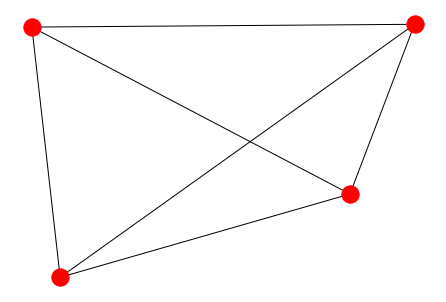

In [3]:
def plot_graph(G):
    plt.figure(figsize=(8,8)) 
    
    layout = nx.spring_layout(G)
    nx.draw_networkx(G, pos=layout)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,layout,edge_labels=labels)
    plt.show()

G = create_graph(2, euclid_dist)
nx.draw(G)

In [4]:
def cost(nodes, G):
    ret = 0
    for i in range(len(nodes)-1):
        u, v = nodes[i], nodes[i+1]
        ret += G[u][v]['weight']
    return ret

In [5]:
def first_min(adj, i):
    minimo = np.inf
    for k in range(len(adj)):
        if(adj[i][k] < minimo and i != k):
            minimo = adj[i][k]
    return minimo

def second_min(adj, i):
    first, second = np.inf, np.inf
    for j in range(len(adj)):
        if i == j:
            continue
        if adj[i][j] <= first:
            second = first
            first = adj[i][j]
        elif adj[i][j] <= second and adj[i][j] != first:
            second = adj[i][j]
    return second

def tsp_rec(adj, curr_bound, curr_weight, level, curr_path):
    global visited
    global final_path
    global final_res
    N = len(adj)

    if level == N:
        if adj[curr_path[level-1]][curr_path[0]] != 0:
            curr_res = curr_weight + adj[curr_path[level-1]][curr_path[0]]

            if curr_res < final_res:
                final_path = curr_path
                final_path[-1] = 0
                final_res = curr_res
        return
    
    for i in range(N):
        if adj[curr_path[level-1]][i] != 0 and visited[i] == 0:
            temp = curr_bound
            curr_weight += adj[curr_path[level-1]][i]

            if (level == 1):
                curr_bound -= ((first_min(adj, curr_path[level-1]) + first_min(adj, i))/2)

            else:
                curr_bound -= ((second_min(adj, curr_path[level-1]) + first_min(adj, i))/2)

            if curr_bound + curr_weight < final_res:
                curr_path[level] = i; 
                visited[i] = 1;
                tsp_rec(adj, curr_bound, curr_weight, level+1, curr_path)  

            curr_weight -= adj[curr_path[level-1]][i]
            curr_bound = temp

            visited = np.zeros(N)
            for j in range(level):
                visited[curr_path[j]] = 1

def TSP(adj):
    global visited
    global final_path
    global final_res
    N = len(adj)
    final_path = np.zeros(N+1,dtype=int)  
    visited = np.zeros(N,dtype=int)
    final_res = np.inf

    curr_path = np.zeros(N+1)
    for i in range(len(curr_path)):
        curr_path[i] = -1
    curr_path = curr_path.tolist()

    curr_bound = 0
    for i in range(N):
        curr_bound = (first_min(adj, i) + second_min(adj, i))

    curr_bound = curr_bound//2 + 1 if curr_bound % 2 == 1 else curr_bound/2
    visited[0] = 1
    curr_path[0] = 0

    tsp_rec(adj, curr_bound, 0, 1, curr_path)
    return final_path, final_res

### Twice-around-the-tree

In [6]:
def twice_around(graph):
    G = graph.copy()
    
    # computar a arvore geradora mínima e adicionar os nós com um caminhamento pré-ordem
    mst = nx.minimum_spanning_tree(G)
    nodes = list(nx.dfs_preorder_nodes(mst, source=0))
    nodes.append(0)
    return nodes, cost(nodes, graph)

### Christofides Algorithm

In [7]:
def christofides(graph):
    G = graph.copy()
    mst = nx.minimum_spanning_tree(G)
    odd_nodes = [node for node in mst if mst.degree(node) % 2 == 1]
    
    induced_graph = G.subgraph(odd_nodes)
    
    # transformar arestas do grafo para pegar o matching mínimo perfeito, como a funcão do
    # network x encontra o matching máximo, multiplicar as arestas por -1 encontra o mínimo. 
    u, v = list(induced_graph.edges())[0]
    for (u, v) in induced_graph.edges():
        induced_graph[u][v]['weight'] *= -1
    
    # matching mínimo perfeito
    matching = nx.max_weight_matching(induced_graph, maxcardinality=True)
    matching_graph = G.edge_subgraph(matching)
    
    # juntar os dois grafos criados a partir da mst e do matching
    multigraph = nx.MultiGraph()
    multigraph.add_weighted_edges_from(mst.edges.data('weight'))
    multigraph.add_weighted_edges_from(matching_graph.edges.data('weight'))
    
    # circuito euleriano
    eulerian = [u for u,v in nx.eulerian_circuit(multigraph, source=0)]
    
    # remover nós repetidos para formar um circuito hamiltoniano
    nodes = []
    for node in eulerian:
        if node not in nodes:
            nodes.append(node)
   
    # adicionando um node source para fechar o circuito
    nodes.append(0)
    
    return nodes, cost(nodes, graph)

In [8]:
christofides(G)

([0, 1, 2, 3, 0], 183)

In [9]:
%time
twice_around(G)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


([0, 3, 1, 2, 0], 179)

In [12]:
G = create_graph(6, euclid_dist)
adj = nx.to_numpy_matrix(G, dtype='int')
adj = adj.tolist()

In [ ]:
plot_graph(G)

## Análise

In [35]:
import time

with open('data.csv', 'w') as f:
    f.write('tsp_func,num_verts,length,time,dist_type\n')

powers = [n for n in range(4, 11)]
dists = [euclid_dist, manhattan_dist]
algorithms = [twice_around, christofides]
algo_str = ["Twice around the tree", "Christofides"]
dist_str = ["Euclides", "Manhattan"]

for power in powers:
    points = (power)
    for i in range(len(algorithms)):
        for j in range(len(dists)):
            G = create_graph(points, dists[i])
            
            start = time.time()
            _, value = algorithms[i](G)
            end = time.time()
            total_time = (end - start) / 60
            ans = algo_str[i] + "," + str((2**power)) + "," + str(value) + "," + str(total_time) + "," + dist_str[j] + "\n"
            
            with open('data.csv', 'a') as f:
                f.write(ans)

In [36]:
import pandas as pd
df = pd.read_csv("data.csv")

In [37]:
df

,tsp_func,num_verts,length,time,dist_type
0,Twice around the tree,16,370,0.000048,Euclides
1,Twice around the tree,16,372,0.000045,Manhattan
2,Christofides,16,478,0.000279,Euclides
3,Christofides,16,508,0.000209,Manhattan
4,Twice around the tree,32,532,0.000096,Euclides
5,Twice around the tree,32,581,0.000075,Manhattan
6,Christofides,32,646,0.000506,Euclides
7,Christofides,32,674,0.000460,Manhattan
8,Twice around the tree,64,792,0.000235,Euclides
9,Twice around the tree,64,791,0.000230,Manhattan
